In [1]:
using LinearAlgebra, Plots, Printf, SparseArrays, IterativeSolvers, LaTeXStrings

Before we look to solve the Poisson equation on a square, let's look at plotting functionality in Julia.

In [2]:
h = .1; m = convert(Int64,1/h)-1;
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x));

In [3]:
f = (x,y) -> (x,y)
U = map(f,X,Y)

9×9 Matrix{Tuple{Float64, Float64}}:
 (0.1, 0.9)  (0.2, 0.9)  (0.3, 0.9)  …  (0.7, 0.9)  (0.8, 0.9)  (0.9, 0.9)
 (0.1, 0.8)  (0.2, 0.8)  (0.3, 0.8)     (0.7, 0.8)  (0.8, 0.8)  (0.9, 0.8)
 (0.1, 0.7)  (0.2, 0.7)  (0.3, 0.7)     (0.7, 0.7)  (0.8, 0.7)  (0.9, 0.7)
 (0.1, 0.6)  (0.2, 0.6)  (0.3, 0.6)     (0.7, 0.6)  (0.8, 0.6)  (0.9, 0.6)
 (0.1, 0.5)  (0.2, 0.5)  (0.3, 0.5)     (0.7, 0.5)  (0.8, 0.5)  (0.9, 0.5)
 (0.1, 0.4)  (0.2, 0.4)  (0.3, 0.4)  …  (0.7, 0.4)  (0.8, 0.4)  (0.9, 0.4)
 (0.1, 0.3)  (0.2, 0.3)  (0.3, 0.3)     (0.7, 0.3)  (0.8, 0.3)  (0.9, 0.3)
 (0.1, 0.2)  (0.2, 0.2)  (0.3, 0.2)     (0.7, 0.2)  (0.8, 0.2)  (0.9, 0.2)
 (0.1, 0.1)  (0.2, 0.1)  (0.3, 0.1)     (0.7, 0.1)  (0.8, 0.1)  (0.9, 0.1)

In [8]:
f = (x,y) -> x*y
U = map(f,X,Y);

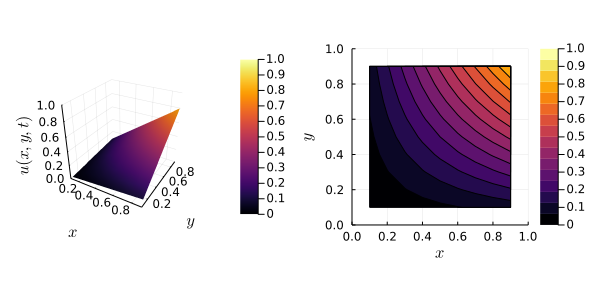

In [9]:
cl = (0,1);
width = 600
p1 = surface(x, y, U[end:-1:1,:], zaxis = [cl[1],cl[2]], clims= cl, aspectratio = 1, xlabel = L"x", ylabel = L"y", zlabel = L"u(x,y,t)")
p2 = contour(x, y, U[end:-1:1,:], clims=cl, xaxis = [0,1], yaxis = [0,1], fill = true, aspectratio = 1, xlabel = L"x", ylabel = L"y")
plot(p1, p2, layout = 2, size = (width, .5width))

Consider the Poisson equation
$$\begin{cases}
-\kappa_1 u_{xx}(x,y) - \kappa_2 u_{yy}(x,y) = f(x,y), \quad (x,y) \in [0,1] \times [0,1],\\
    u(x,0) = g_0(x),\\
    u(x,1) = g_1(x),\\
    u(0,y) = h_0(y),\\
    u(1,y) = h_1(y).
\end{cases}$$

In [40]:
m = 499
h = 1/(m + 1)
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x));

In [41]:
f = (x,y) -> exp(-(x-0.5)^2 - (y-0.5)^2)
G = (x,y) -> sin(x)*cos(y)^2 + 1/(1 + x^2)

#71 (generic function with 1 method)

In [42]:
g0 = x -> G(x,0)
g1 = x -> G(x,1)
h0 = y -> G(0,y)
h1 = y -> G(1,y)

#79 (generic function with 1 method)

In [43]:
e1 = zeros(m); e1[1] = 1.0;
em = zeros(m); em[end] = 1.0;
κ1 = 1.0; κ2 = 2.0;

In [44]:
A1 = κ1/h^2*SymTridiagonal(fill(2.0,m),fill(-1.0,m-1));
A2 = κ2/h^2*SymTridiagonal(fill(2.0,m),fill(-1.0,m-1));
F = map(f,X,Y)
F += κ1*h^(-2)*map(h1,y)*em' + κ1*h^(-2)*map(h0,y)*e1'
F += κ2*h^(-2)*em*map(g0,x)' + κ2*h^(-2)*e1*map(g1,x)';

In [45]:
function CG(f,b,⋄,eps::Float64;kmax = 1e6, resflag = false)
   x = 0.0*b; r = b; p = r; n = 0;
   for j = 1:kmax
        n = j
        q = f(p)
        a = (r⋄r)/(p⋄q)
        x = x + a*p
        r_old = r
        r = r - a*q
        if resflag
            println(sqrt(r⋄r))
        end
        if sqrt(r⋄r) < eps
            break
        end
        b = (r⋄r)/(r_old⋄r_old)
        p = r + b*p
        
    end
    @printf("CG took %i iterations",n)
    x
end

function CG(f,g,b,⋄,eps::Float64;kmax = 1e6, resflag = false)
   x = 0.0*b; r = b; n = 0; z = g(r);  p = z;
   for j = 1:kmax
        n = j
        w = f(p)
        a = (z⋄r)/(p⋄w)
        x = x + a*p
        r_old = r
        z_old = z
        r = r - a*w
        if resflag
            println(sqrt(r⋄r))
        end
        if sqrt(r⋄r) < eps
            break
        end
        z = g(r)
        b = (z⋄r)/(z_old⋄r_old)
        p = z + b*p 
    end
    @printf("CG took %i iterations \n",n)
    x
end

CG (generic function with 2 methods)

In [46]:
f = X -> A2*X + X*A1
function ⋄(X,Y)
    h^2*dot(X,Y)
end
g = X -> (.5A2+I/h^2)\((.5A1+I/h^2)\X')'

#85 (generic function with 1 method)

In [47]:
U = CG(f,g,F,⋄,h^2; resflag = false)

CG took 668 iterations 


499×499 Matrix{Float64}:
 1.00057  1.00114  1.00169  1.00225  1.00279  …  0.837778  0.881209  0.988531
 1.00056  1.00112  1.00168  1.00222  1.00276     0.917118  0.983453  1.10792
 1.00056  1.00111  1.00166  1.0022   1.00274     0.982506  1.05663   1.17278
 1.00055  1.0011   1.00164  1.00218  1.00271     1.03485   1.10879   1.21137
 1.00055  1.00109  1.00163  1.00216  1.00269     1.0764    1.14662   1.23624
 1.00054  1.00108  1.00162  1.00215  1.00267  …  1.1095    1.17476   1.25334
 1.00054  1.00107  1.0016   1.00213  1.00265     1.1361    1.19624   1.26574
 1.00053  1.00107  1.00159  1.00212  1.00264     1.15773   1.21304   1.27509
 1.00053  1.00106  1.00158  1.00211  1.00262     1.17553   1.22647   1.28238
 1.00053  1.00105  1.00158  1.00209  1.00261     1.19038   1.23742   1.28821
 1.00053  1.00105  1.00157  1.00208  1.00259  …  1.20289   1.24648   1.29297
 1.00052  1.00104  1.00156  1.00207  1.00258     1.21356   1.2541    1.29692
 1.00052  1.00104  1.00155  1.00206  1.00257     1

In [48]:
*(size(U)...)

249001

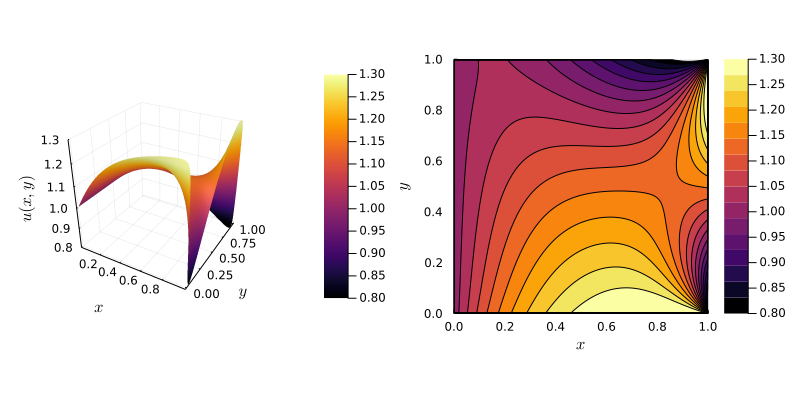

In [49]:
cl = (.8,1.3);
width = 800
p1 = surface(x, y, U[end:-1:1,:], zaxis = [cl[1],cl[2]], clims= cl, aspectratio = 1, xlabel = L"x", ylabel = L"y", zlabel = L"u(x,y)")
p2 = contour(x, y, U[end:-1:1,:], clims=cl, xaxis = [0,1], yaxis = [0,1], fill = true, aspectratio = 1, xlabel = L"x", ylabel = L"y")
plot(p1, p2, layout = 2, size = (width, .5width))

Using vec() and mat()

In [51]:
*([1,2,3]...)

6

In [50]:
vec = X -> vcat([X[:,i] for i = 1:m])
mat = x -> reshape(x, (m,m))

#91 (generic function with 1 method)

In [54]:
J = kron(sparse(I,m,m),A2|>sparse) + kron(A1 |> sparse, sparse(I,m,m))

249001×249001 SparseMatrixCSC{Float64, Int64} with 1243009 stored entries:
⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦

In [55]:
U - mat(J\vec(F)) |> norm

6.168517042762599e-7

Ill-posed problems

In [56]:
g = x -> cos(3*x*pi) + 0.1*cos(x*pi)
α = 0.0;
β = 0.0;

In [58]:
m = 49;
h = 1.0/(m + 1);
x = 0:h:1
A = SymTridiagonal(fill(2.0,m+2),fill(-1.0,m+1)) |> sparse
A[1,1] = 2; A[1,2] = -2
A[end,end] = 2; A[end,end-1] = -2
A *= h^(-2);

Ap = SymTridiagonal(fill(2.0,m+2),fill(-1.0,m+1));
Ap *= h^(-2);
Fp = x -> Ap\x

b = map(g,x)
b[1] += 2α/h
b[end] -= 2β/h;

In [59]:
eigen(A |> Array).values

51-element Vector{Float64}:
    1.7269332779731469e-12
    9.866357858643912
   39.42649342761261
   88.56374635655904
  157.08419435684493
  244.71741852423386
  351.11757055874347
  475.86473766990184
  618.4665997806817
  778.3603724899225
  954.9150281252626
 1147.4337861210545
 1355.1568628929426
    ⋮
 8852.56621387894
 9045.084971874725
 9221.639627510061
 9381.533400219298
 9524.135262330079
 9648.882429441253
 9755.28258147576
 9842.91580564315
 9911.436253643436
 9960.573506572364
 9990.133642141333
 9999.999999999976

In [60]:
F = x -> A*x
cc = ones(m+2); cc /= norm(cc);
G = x -> (x - cc*(cc'*x))
function ⋄(x,y)
    dot(x,y)
end

⋄ (generic function with 1 method)

In [61]:
dot(cc,b)

-3.18658884526358e-17

In [65]:
U = CG(F,b,⋄,1e-6; kmax = 100000, resflag = false)

CG took 100000 iterations

51-element Vector{Float64}:
  0.02142687384719321
  0.021206872812138605
  0.020554033497000995
  0.01948959555409398
  0.018048131267018742
  0.016276336221744375
  0.014231389291295141
  0.0119789425784074
  0.009590826456389957
  0.007142540278988664
  0.004710613862639072
  0.0023699330782977084
  0.0001911332694700954
  ⋮
 -0.0023699258457264673
 -0.004710616771204895
 -0.007142554666704078
 -0.009590856453626057
 -0.011978995915869536
 -0.01423147097390083
 -0.01627644426580579
 -0.018048257623662294
 -0.01948973267443321
 -0.020554177788837894
 -0.02120702176285643
 -0.02142702443796791

In [66]:
U = CG(F,G,G(b),⋄,1e-6; kmax = 100000, resflag = false)

CG took 1708 iterations 


51-element Vector{Float64}:
  0.02142675111163184
  0.021206751088224108
  0.020553915082446146
  0.019489483956280616
  0.018048030258082264
  0.01627624582513885
  0.01423130500662382
  0.01197886134121363
  0.009590748536103316
  0.007142467230977002
  0.004710546165696955
  0.0023698712928811308
  0.00019107742070939045
  ⋮
 -0.002369871459920765
 -0.004710546209409741
 -0.007142467166613008
 -0.009590748371413813
 -0.011978861093760493
 -0.014231304756624957
 -0.016276245655000986
 -0.018048030186274773
 -0.019489483925693996
 -0.020553915032653223
 -0.021206750996039497
 -0.021426750998940487

In [ ]:
norm(A*U-b)

In [ ]:
plot(x,U)
#plot!(x,cos.(3pi*x)/(9pi^2))

Another approach

In [67]:
cc = ones(m+2);
cc[1] -= norm(cc)
cc = cc/norm(cc);
H = x -> x - 2*cc*(cc'*x)
P = x -> H(vcat([0.0],x))
Pt = x -> H(x)[2:end]

#109 (generic function with 1 method)

In [68]:
F = x -> Pt(A*P(x))
function ⋄(x,y)
    dot(x,y)
end

⋄ (generic function with 1 method)

In [69]:
U = CG(F,Pt(b),⋄,1e-6; kmax = 10000, resflag = false)

CG took 2650 iterations

50-element Vector{Float64}:
  0.024695644401203923
  0.024042808394402523
  0.02297837725354771
  0.021536923516121062
  0.019765139080910998
  0.017720198334161462
  0.015467754791255959
  0.01307964215893196
  0.010631361034491181
  0.008199440091233854
  0.005858765211259147
  0.0036799711492374286
  0.0017269878606441624
  ⋮
  0.0011190112273340859
 -0.001221663854711715
 -0.003653584964065178
 -0.006101866181455913
 -0.008489978851050588
 -0.010742422387128718
 -0.012787363152425629
 -0.014559147601641068
 -0.01600060127264375
 -0.017065032263235573
 -0.017717868132498777
 -0.01793786810517595

In [ ]:
id = Matrix(I,m+1,m+1)
A_low = hcat([F(id[:,j]) for j = 1:m+1]...)

In [ ]:
κ = cond(A_low)

In [ ]:
cond(A |> Matrix)

Estimate iteration count:

$$ \|e_k\|_A \leq 2 \left( \frac{\sqrt{\kappa} -1}{\sqrt{\kappa + 1}} \right)^k.$$

To acheive $\epsilon$ accuracy

$$ k \leq  \frac{\log(\epsilon /2)}{\log\left( \frac{\sqrt{\kappa} -1}{\sqrt{\kappa + 1}} \right)}.$$

In [ ]:
log(1e-6/2)/log((sqrt(κ)-1)/(sqrt(κ)+1))

In [ ]:
κ = cond(kron(A_low,Matrix(I,m+1,m+1)) + kron(Matrix(I,m+1,m+1),A_low))

In [ ]:
log(1e-6/2)/log((sqrt(κ)-1)/(sqrt(κ)+1))

In [ ]:
CG(x -> Ap*x,rand(m+2),⋄,1e-6;resflag = true)

In [ ]:
cond(Ap |> Matrix)

In [ ]:
CG(X -> A_low*X + X*A_low, randn(m+1,m+1), ⋄, 1e-6)